# **Population-Level Sleep Pattern Analysis for Public Health**
## **Objective:**
to study how people’s sleep habits are different based on their age, gender, or lifestyle, and how sleep is connected to health problems like depression, obesity, and diabetes.

## **User Story**

As a **public health researcher**, I want to analyse sleep patterns across different age groups, genders, and lifestyles, so that I can understand how poor sleep is related to chronic health issues like depression, obesity, and diabetes, and recommend interventions at a population level.

## **Dataset**
- [NSRR- Sleep Heart Health Study](https://sleepdata.org/datasets/shhs/files)
- [Sleep-EDF](https://physionet.org/content/sleep-edfx/1.0.0/)

In [ ]:
!pip install mne
!pip install xmltodict

## **Import libraries**

In [ ]:
import mne, xmltodict
import matplotlib.pyplot as plt
import numpy as np, random
import pandas as pd
import os
from glob import glob
import re
from pathlib import Path
from collections import Counter
from google.colab import drive


import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset

from scipy.signal import butter, filtfilt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

## **Connect with google drive**

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Setting paths**

In [ ]:
BASE = Path('/content/drive/MyDrive/NSRR_project')
BASE.exists(), BASE

(True, PosixPath('/content/drive/MyDrive/NSRR_project'))

In [ ]:
edfs = sorted(glob(str(BASE / '*.edf')))
xmls = sorted(glob(str(BASE / '*.xml')))
print(len(edfs), 'EDF files')
print(len(xmls), 'XML files')
print(edfs[:3])
print(xmls[:3])


120 EDF files
122 XML files
['/content/drive/MyDrive/NSRR_project/SHHS 200001.edf', '/content/drive/MyDrive/NSRR_project/SHHS 200002.edf', '/content/drive/MyDrive/NSRR_project/SHHS 200003.edf']
['/content/drive/MyDrive/NSRR_project/SHHS 200001 Data.xml', '/content/drive/MyDrive/NSRR_project/SHHS 200002 Data.xml', '/content/drive/MyDrive/NSRR_project/SHHS 200003 Data.xml']


In [ ]:
edfs = [Path(p) for p in glob(str(BASE / '*.edf'))]
xmls = [Path(p) for p in glob(str(BASE / '*.xml'))]

def subj_id(p: Path):
    """Extract 6-digit ID like 200001 from any filename."""
    m = re.search(r'(\d{6})', p.stem)
    return m.group(1) if m else None

edf_by_id = {subj_id(p): p for p in edfs if subj_id(p)}
xml_by_id = {}
for p in xmls:
    sid = subj_id(p)
    if sid and sid not in xml_by_id:
        xml_by_id[sid] = p

pairs = [(edf_by_id[i], xml_by_id[i]) for i in edf_by_id.keys() if i in xml_by_id]
print(f"Found {len(edfs)} EDFs, {len(xmls)} XMLs, {len(pairs)} paired.")

pairs[:3]

Found 120 EDFs, 122 XMLs, 120 paired.


[(PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200001.edf'),
  PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200001 Data.xml')),
 (PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200007.edf'),
  PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200007 Data.xml')),
 (PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200002.edf'),
  PosixPath('/content/drive/MyDrive/NSRR_project/SHHS 200002 Data.xml'))]

## **Loading the datasets**
### **Sources**
- **Demographics:** per-participant age, sex, BMI, lifestyle/health variables (e.g., smoking, diabetes, depression).
- **EDF (PSG signals):** overnight polysomnography recordings.
- **XML (annotations):** scored events aligned to the EDF timeline.



In [ ]:
#choose the first pair
edf_path, xml_path = pairs[0]

raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


with open(xml_path, 'rb') as f:
    d = xmltodict.parse(f.read())

events = d.get('PSGAnnotation', {}).get('ScoredEvents', {}).get('ScoredEvent', [])
if isinstance(events, dict): events = [events]

# parsed = []
# for ev in events:
#     concept = ev.get('EventConcept') or ev.get('Name') or ''
#     start = float(ev.get('Start', 0))
#     dur   = float(ev.get('Duration', 0))
#     parsed.append((concept, start, dur))

# print(f'Parsed {len(parsed)} events from XML (example):', parsed[:5])

EEG signals

Using matplotlib as 2D backend.


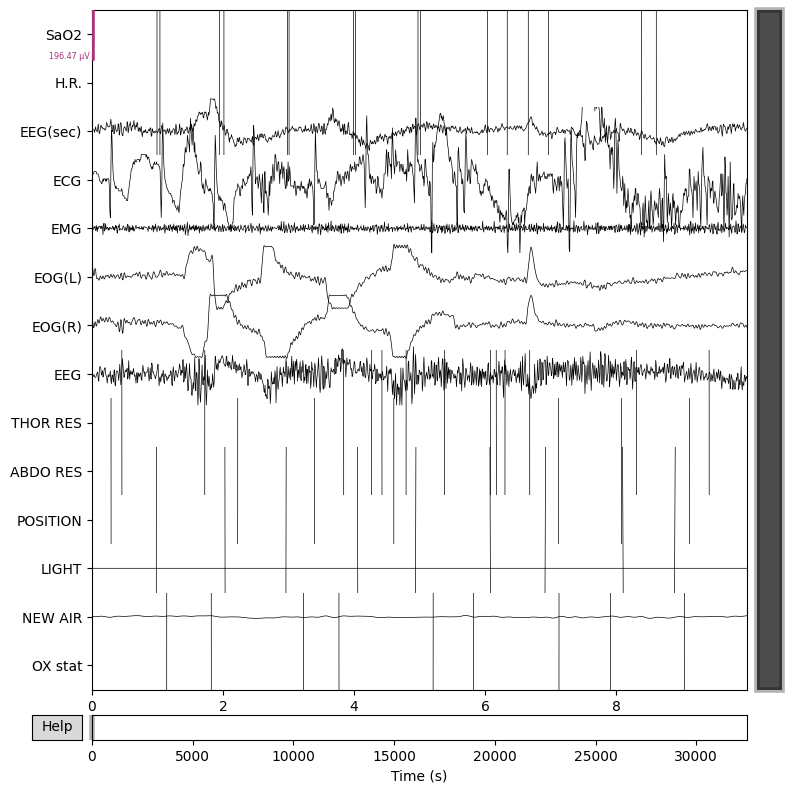

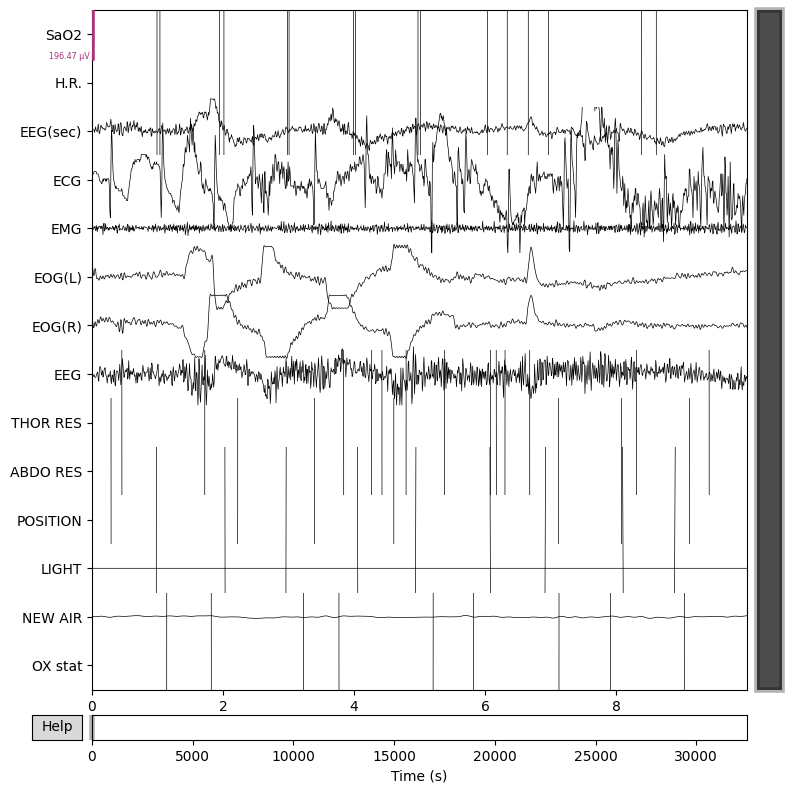

In [ ]:
raw.plot(title="Raw EEG", scalings="auto", show=True)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


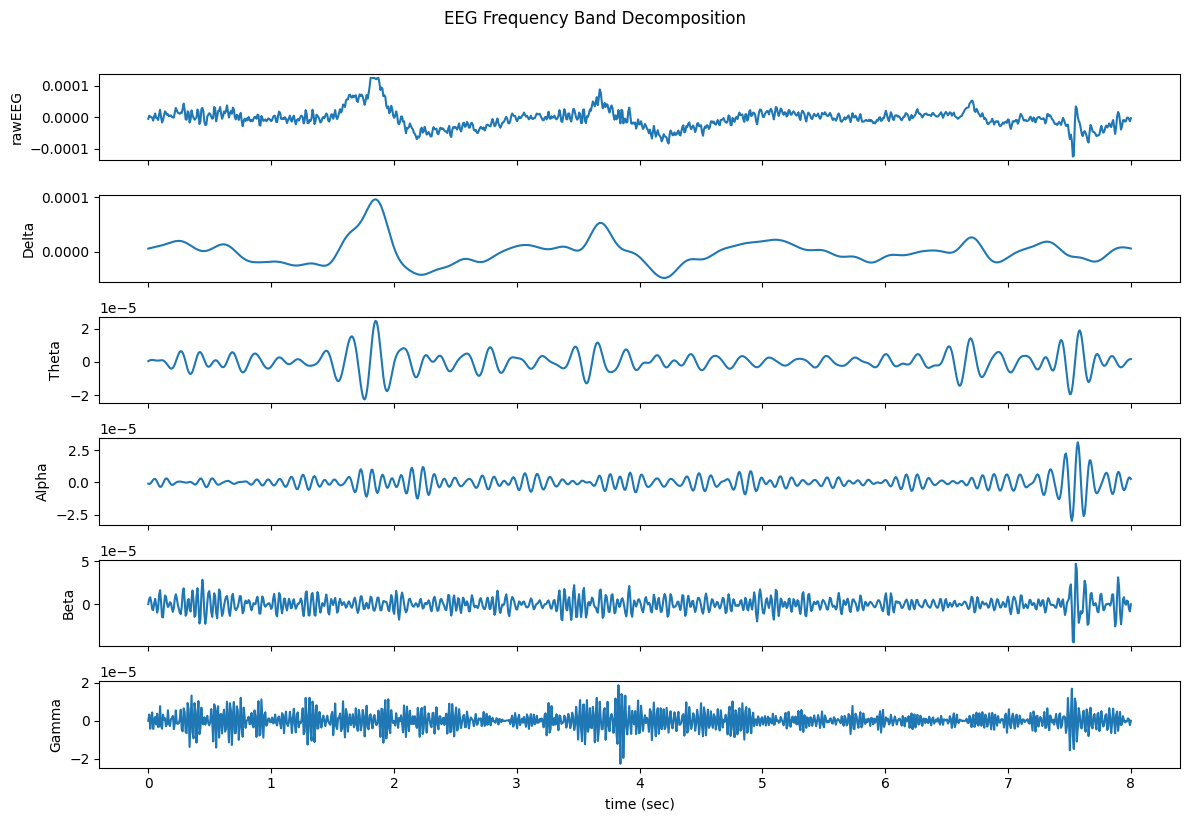

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low  = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y
# Use first EEG channel
eeg_ch = [ch for ch in raw.ch_names if 'EEG' in ch.upper()][0]
raw.pick_channels([eeg_ch])

# Sampling rate
fs = int(raw.info['sfreq'])

# Select 8 seconds from the signal
start_sec = 0
duration_sec = 8
start_sample = start_sec * fs
end_sample = start_sample + duration_sec * fs

signal, times = raw[:, start_sample:end_sample]
signal = signal[0]  # 1D
t = np.linspace(0, duration_sec, len(signal))

delta = bandpass_filter(signal, 0.5, 4, fs)
theta = bandpass_filter(signal, 4, 8, fs)
alpha = bandpass_filter(signal, 8, 13, fs)
beta  = bandpass_filter(signal, 13, 30, fs)
gamma = bandpass_filter(signal, 30, 50, fs)

fig, axs = plt.subplots(6, 1, figsize=(12, 8), sharex=True)

axs[0].plot(t, signal)
axs[0].set_ylabel('rawEEG')

axs[1].plot(t, delta)
axs[1].set_ylabel('Delta')

axs[2].plot(t, theta)
axs[2].set_ylabel('Theta')

axs[3].plot(t, alpha)
axs[3].set_ylabel('Alpha')

axs[4].plot(t, beta)
axs[4].set_ylabel('Beta')

axs[5].plot(t, gamma)
axs[5].set_ylabel('Gamma')
axs[5].set_xlabel('time (sec)')

plt.suptitle('EEG Frequency Band Decomposition', y=1.02)
plt.tight_layout()
plt.show()





### Understanding EEG Signals in Sleep Studies

EEG signals are recorded using small electrodes placed on the scalp. These electrodes detect brain waves, which are then amplified and visualized as waveforms. Each type of brain wave corresponds to different states of alertness or sleep.

### Common EEG Frequency Bands:
| Band  | Frequency (Hz) | Sleep Stage / Meaning         |
|-------|----------------|-------------------------------|
| Delta | 0.5–4 Hz       | Deep sleep (N3)               |
| Theta | 4–8 Hz         | Light sleep (N1, N2)          |
| Alpha | 8–13 Hz        | Relaxed wakefulness, drowsy   |
| Beta  | 13–30 Hz       | Wakefulness, REM sleep        |

During a full night’s sleep, EEG signals naturally shift across these bands as the person transitions through different sleep stages.

This project uses EEG data to:
- **Visualize sleep stages** over time (hypnogram)
- **Quantify time spent in each sleep stage**
- **Detect abnormal patterns** that may relate to health conditions like insomnia or sleep apnea


In [ ]:
# build a clean events dataframe
rows = []
for ev in events if isinstance(events, list) else [events]:
    concept = (ev.get('EventConcept') or ev.get('Name') or '').strip()
    start   = float(ev.get('Start', 0.0))
    dur     = float(ev.get('Duration', 0.0))
    rows.append(dict(concept=concept, start_sec=start, duration_sec=dur, end_sec=start+dur))

ev_df = (pd.DataFrame(rows)
           .sort_values('start_sec')
           .assign(start_time=lambda d: pd.to_timedelta(d.start_sec, unit='s'),
                   end_time=lambda d: pd.to_timedelta(d.end_sec,   unit='s'))
           .reset_index(drop=True))

display(ev_df.head(20))
print("Events:", len(ev_df))


,concept,start_sec,duration_sec,end_sec,start_time,end_time
0,Recording Start Time,0.0,32520.0,32520.0,0 days 00:00:00,0 days 09:02:00
1,Wake|0,0.0,840.0,840.0,0 days 00:00:00,0 days 00:14:00
2,SpO2 artifact|SpO2 artifact,304.0,3.0,307.0,0 days 00:05:04,0 days 00:05:07
3,Stage 1 sleep|1,840.0,30.0,870.0,0 days 00:14:00,0 days 00:14:30
4,Stage 2 sleep|2,870.0,90.0,960.0,0 days 00:14:30,0 days 00:16:00
5,Wake|0,960.0,30.0,990.0,0 days 00:16:00,0 days 00:16:30
6,Arousal|Arousal (),964.8,25.4,990.2,0 days 00:16:04.800000,0 days 00:16:30.200000
7,Stage 1 sleep|1,990.0,30.0,1020.0,0 days 00:16:30,0 days 00:17:00
8,Stage 2 sleep|2,1020.0,270.0,1290.0,0 days 00:17:00,0 days 00:21:30
9,Stage 3 sleep|3,1290.0,120.0,1410.0,0 days 00:21:30,0 days 00:23:30


Events: 552


### **Polysomnography signals**

The dataset used in this study comes from the **Sleep Heart Health Study (NSRR)**, a large-scale, community-based cohort study investigating the relationship between sleep-disordered breathing and cardiovascular outcomes.  
The dataset contains **polysomnography (PSG)** recordings and accompanying demographic information.
| Column         | Meaning                                                                                  |
|----------------|-------------------------------------------------------------------------------------------|
| `concept`      | Event label (e.g., `Wake 0`, `Stage 1/2/3`, `REM`, `Arousal/Arousal ()`, `SpO2 artifact`). |
| `start_sec`    | Event start time in **seconds** from recording start.                                     |
| `duration_sec` | Event duration in seconds (sleep stages usually come in **30 s** blocks).                 |
| `end_sec`      | `start_sec + duration_sec`.                                                               |
| `start_time`   | Human-readable start time since recording start.                                          |
| `end_time`     | Human-readable end time since recording start.                                            |


In [ ]:
meta_path = BASE / 'SHHS_Harmonized_Dataset.csv'
demo_data = pd.read_csv(meta_path, low_memory=False)
print("Shape:", demo_data.shape)
demo_data[101:].head(10)


Shape: (10115, 29)


,nsrrid,visitnumber,nsrr_age,nsrr_age_gt89,nsrr_sex,nsrr_race,nsrr_ethnicity,nsrr_bmi,nsrr_bp_systolic,nsrr_bp_diastolic,...,nsrr_ttleffsp_f1,nsrr_ttllatsp_f1,nsrr_ttlprdsp_s1sr,nsrr_ttldursp_s1sr,nsrr_ttldurws_f1,nsrr_pctdursp_s1,nsrr_pctdursp_s2,nsrr_pctdursp_s3,nsrr_pctdursp_sr,nsrr_ttlprdbd_f1
101,200102,1,47.0,no,female,white,not hispanic or latino,29.660457,110.0,80.0,...,83.52,8.0,68.5,67.0,73.0,1.83,53.84,23.87,20.46,491.5
102,200103,1,51.0,no,male,white,not hispanic or latino,31.309074,148.0,102.0,...,84.69,0.0,354.5,282.0,74.5,3.16,36.65,46.00,14.20,486.5
103,200104,1,71.0,no,female,white,not hispanic or latino,28.305995,150.0,90.0,...,48.19,21.5,59.0,59.0,193.0,6.02,47.37,22.31,24.31,414.0
104,200105,1,53.0,no,male,white,not hispanic or latino,25.982317,110.0,80.0,...,88.28,0.0,147.5,125.5,34.0,2.15,64.84,20.90,12.11,290.0
105,200106,1,54.0,no,male,white,not hispanic or latino,21.728997,110.0,72.0,...,80.97,0.0,44.0,30.5,90.0,4.96,60.57,1.04,33.42,473.0
106,200107,1,66.0,no,male,white,not hispanic or latino,21.886815,124.0,80.0,...,93.89,0.0,63.0,58.5,29.0,1.23,73.88,0.34,24.55,475.0
107,200108,1,60.0,no,female,white,not hispanic or latino,27.730121,100.0,70.0,...,84.60,22.5,171.0,141.5,43.5,3.31,59.72,15.59,21.38,428.5
108,200109,1,71.0,no,female,white,not hispanic or latino,24.161736,144.0,80.0,...,86.95,15.0,125.5,119.5,44.0,8.02,38.30,42.75,10.94,452.0
109,200110,1,58.0,no,male,white,not hispanic or latino,27.582177,112.0,64.0,...,94.06,0.0,40.5,40.0,24.5,2.96,83.76,0.90,12.37,412.5
110,200111,1,65.0,no,female,white,not hispanic or latino,23.802195,144.0,78.0,...,85.50,24.0,73.5,72.0,9.5,1.01,48.61,35.44,14.94,231.0


In [ ]:
print("\nDtypes:\n", demo_data.dtypes.head(30))


Dtypes:
 nsrrid                    int64
visitnumber               int64
nsrr_age                float64
nsrr_age_gt89            object
nsrr_sex                 object
nsrr_race                object
nsrr_ethnicity           object
nsrr_bmi                float64
nsrr_bp_systolic        float64
nsrr_bp_diastolic       float64
nsrr_current_smoker      object
nsrr_ever_smoker         object
nsrr_ahi_hp3u           float64
nsrr_ahi_hp3r_aasm15    float64
nsrr_ahi_hp4u_aasm15    float64
nsrr_ahi_hp4r           float64
nsrr_ttldursp_f1        float64
nsrr_phrnumar_f1        float64
nsrr_flag_spsw           object
nsrr_ttleffsp_f1        float64
nsrr_ttllatsp_f1        float64
nsrr_ttlprdsp_s1sr      float64
nsrr_ttldursp_s1sr      float64
nsrr_ttldurws_f1        float64
nsrr_pctdursp_s1        float64
nsrr_pctdursp_s2        float64
nsrr_pctdursp_s3        float64
nsrr_pctdursp_sr        float64
nsrr_ttlprdbd_f1        float64
dtype: object


### **Demographic Data**
The SHHS (Sleep Heart Health Study) Harmonized Dataset is a cleaned and standardized version of the original SHHS data, curated by the NSRR (National Sleep Research Resource). This dataset combines key sleep and demographic information across multiple SHHS visits into a single, unified structure for analysis.

- **Dataset name**: SHHS Harmonized Dataset
- **Total rows (subjects)**: 10115
- **Total columns (variables)**: 29
- **ID field**: `nsrrid`



| Column Name            | Description                                  | Example       |
|------------------------|----------------------------------------------|---------------|
| `nsrr_age`             | Participant's age at time of visit           | `56`          |
| `nsrr_sex`             | Biological sex                               | `Male`        |
| `nsrr_bmi`             | Body Mass Index                              | `28.4`        |
| `nsrr_ahi_hp3u`        | Apnea-Hypopnea Index (recommended formula)   | `17.3`        |
| `nsrr_se_pct`          | Sleep efficiency (%)                         | `88.5`        |
| `nsrr_remdursp`        | REM sleep duration (minutes)                 | `79.2`        |

---


### **Demographic data analysis**

1. Distribution of Sleep Efficiency (`nsrr_ttleffsp_f1`)

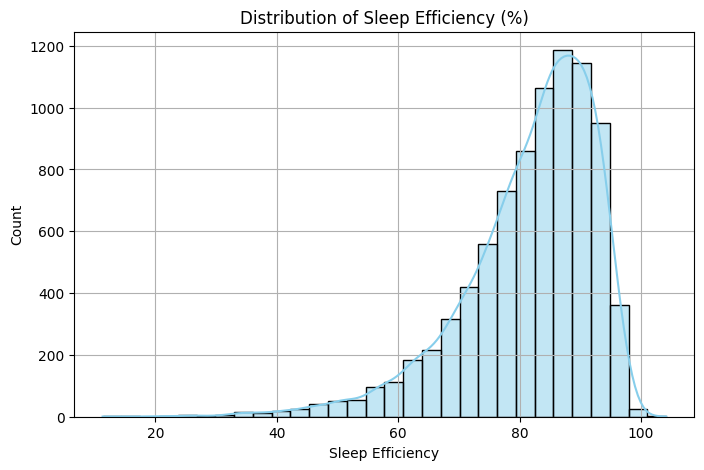

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(data=demo_data, x='nsrr_ttleffsp_f1', kde=True, bins=30, color='skyblue')
plt.title("Distribution of Sleep Efficiency (%)")
plt.xlabel("Sleep Efficiency")
plt.ylabel("Count")
plt.grid(True)
plt.show()


**Distribution of Sleep Efficiency (%)**

This histogram shows how **sleep efficiency** is spread out across all participants in the dataset.

- Most people have a sleep efficiency between **80% and 90%**.
- Very few people have very **low** (below 50%) or **very high** (close to 100%) sleep efficiency.
- The shape of the graph is **right-skewed**, meaning more people sleep efficiently while fewer have very poor sleep.
- The smooth blue curve (KDE) shows the overall pattern or trend.
- This graph helps us understand that **low sleep efficiency is not common**, but still present in some cases.

We can use this insight to focus on **why some people have poor sleep** and how it relates to their health, age, or lifestyle.


2. Sleep Efficiency by Age Group

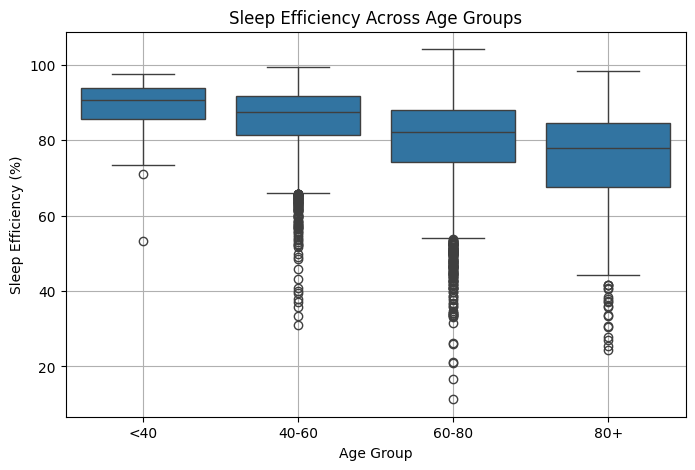

In [ ]:
demo_data['age_group'] = pd.cut(demo_data['nsrr_age'], bins=[0, 40, 60, 80, 100], labels=['<40', '40-60', '60-80', '80+'])

plt.figure(figsize=(8,5))
sns.boxplot(data=demo_data, x='age_group', y='nsrr_ttleffsp_f1')
plt.title("Sleep Efficiency Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Sleep Efficiency (%)")
plt.grid(True)
plt.show()


**Sleep Efficiency Across Age Groups**

This boxplot compares **sleep efficiency** among different **age groups**:

- People **under 40** generally have the **highest** sleep efficiency, with most values above **85%**.
- As age increases, **sleep efficiency tends to decrease**.
- The **60–80** and **80+** groups show **lower medians** and **more outliers**, meaning more people in these age groups sleep less efficiently.
- The **black lines** in each box show the **median (middle value)**.
- The **dots below the boxes** are **outliers**—people whose sleep efficiency is much lower than others in the same age group.

This graph tells us that **older adults often experience worse sleep**, and there is **more variation** in their sleep efficiency. It may help health researchers understand how age impacts sleep quality.


3. Sleep Efficiency by Sex

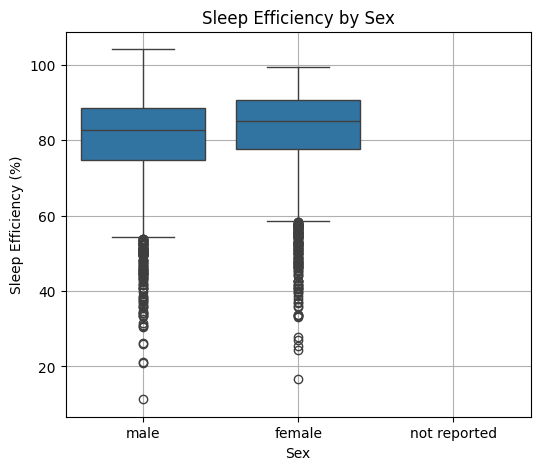

In [ ]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=demo_data, x='nsrr_sex', y='nsrr_ttleffsp_f1')
plt.title("Sleep Efficiency by Sex")
plt.xlabel("Sex")
plt.ylabel("Sleep Efficiency (%)")
plt.grid(True)
plt.show()

**Sleep Efficiency by Sex**

This boxplot compares **sleep efficiency** between **males** and **females**:

- **Both males and females** have similar **median sleep efficiency**, around **85%**.
- The **female group** shows slightly **higher and tighter** sleep efficiency overall.
- **Males** have a **wider spread** with more **low sleep efficiency outliers**.
- The group marked **"not reported"** had no visible data or very few samples.

This graph suggests that **females may have slightly better and more consistent sleep efficiency** than males, but the difference is not very large. Outliers (dots) show individuals with poor sleep in both groups.


4. Correlation Heatmap

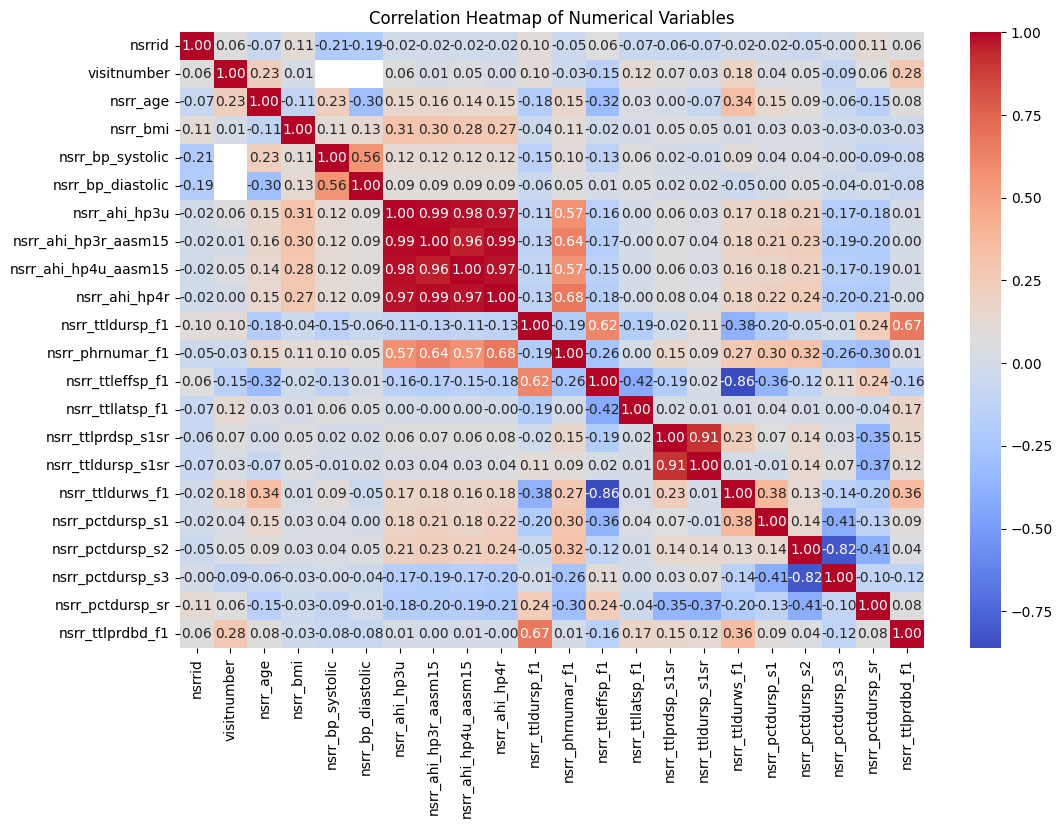

In [ ]:
num_cols = demo_data.select_dtypes(include='number')
plt.figure(figsize=(12, 8))
sns.heatmap(num_cols.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()


**Correlation Heatmap of Numerical Variables**

This heatmap shows how different **numerical features** in the dataset are related to each other using **correlation values** (from -1 to +1):

- **Red = strong positive correlation**, meaning both values go up together.
- **Blue = strong negative correlation**, meaning one goes up while the other goes down.
- **White = no correlation** (around 0), meaning there's little or no linear relationship.


**Key observations:**
- **Apnea indexes** (`nsrr_ahi_hp3u`, `hp3r_aasm15`, `hp4u_aasm15`, `hp4r`) are **strongly correlated** with each other (close to 1.00).
- **Sleep efficiency** (`nsrr_ttleffsp_f1`) has a **negative correlation** with sleep latency (`nsrr_ttllatsp_f1`) and **positive correlation** with `nsrr_pctdursp_s2` (light sleep).
- **Total sleep durations** (e.g., `nsrr_ttldursp_f1`, `nsrr_ttldurws_f1`) also show moderate correlations with sleep quality metrics.

5. Impact of Smoking on Sleep Efficiency

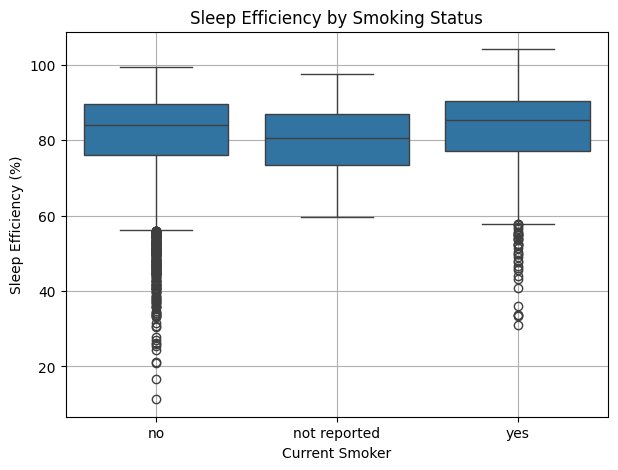

In [ ]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=demo_data, x='nsrr_current_smoker', y='nsrr_ttleffsp_f1')
plt.title("Sleep Efficiency by Smoking Status")
plt.xlabel("Current Smoker")
plt.ylabel("Sleep Efficiency (%)")
plt.grid(True)
plt.show()


**Sleep Efficiency by Smoking Status**

This boxplot compares **sleep efficiency** across three groups based on their **current smoking status**:

- **"No"** (non-smokers)
- **"Yes"** (current smokers)
- **"Not reported"** (missing or undisclosed data)

**Key observations:**
- The **median sleep efficiency** is slightly higher in **current smokers**, but the difference between smokers and non-smokers is **not very large**.
- All groups have a wide range of sleep efficiency, with some **outliers** having very low values.
- The **spread (IQR)** of values is quite similar between the groups.

This suggests that **smoking status may not have a strong impact** on sleep efficiency in this dataset, though other health or lifestyle factors might still play a role.


## **Data Wrangling Processing**

- Merged sleep information with demographic data using the subject ID (`sid6` or equivalent).
- Dropped unnecessary columns to reduce noise and improve model performance.
- Handled missing values by dropping rows with missing BMI, as only two rows were affected.



### **Demographic Data Preprocessing**

1. **Selected relevant features**  
   Extracted a subset of demographic columns from the dataset:
   - `nsrrid`: subject ID  
   - `nsrr_age`: participant's age  
   - `nsrr_sex`: biological sex  
   - `nsrr_bmi`: body mass index  
   - `nsrr_race`: race category  
   - `nsrr_current_smoker`: smoking status (current)

2. **Removed missing data**  
   Dropped any rows that had missing (`NaN`) values in the selected columns to ensure a clean input for modeling.

3. **Encoded categorical variables**
   - Converted the `nsrr_sex` column to binary:  
     - `male` → `0`  
     - `female` → `1`
   - Applied one-hot encoding to:
     - `nsrr_race` (e.g., White, Black, etc.)
     - `nsrr_current_smoker` (e.g., Yes, No)

4. **Normalized continuous features**  
   Scaled `nsrr_age` and `nsrr_bmi` to the range [0, 1] using **Min-Max scaling** to improve neural network performance.


In [ ]:

demo = demo_data[[
    'nsrrid',               # identifiers
    'nsrr_age', 'nsrr_sex',         # age and gender
    'nsrr_bmi',                     # BMI
    'nsrr_current_smoker',         # smoking status
    'nsrr_bp_systolic', 'nsrr_bp_diastolic',  # blood pressure
    'nsrr_ttleffsp_f1'             # target: sleep efficiency
]]
#clean missing values
demo = demo.dropna()
# Encode categorical
demo['nsrr_sex'] = demo['nsrr_sex'].map({'male':0,'female':1})
demo = pd.get_dummies(demo, columns=['nsrr_current_smoker'])
#normalize
# 1. Normalize input features
scaler_X = MinMaxScaler()
demo[['nsrr_age','nsrr_bmi','nsrr_bp_systolic','nsrr_bp_diastolic']] = scaler_X.fit_transform(
    demo[['nsrr_age','nsrr_bmi','nsrr_bp_systolic','nsrr_bp_diastolic']]
)

# 2. Normalize target separately
scaler_y = MinMaxScaler()
demo['nsrr_ttleffsp_f1'] = scaler_y.fit_transform(
    demo[['nsrr_ttleffsp_f1']]
)
y = demo['nsrr_ttleffsp_f1'].values.astype(np.float32)

demo = demo.dropna()
demo['sid6'] = demo['nsrrid'].astype(str).str.extract(r'(\d{6})$')



In [ ]:
demo

,nsrrid,nsrr_age,nsrr_sex,nsrr_bmi,nsrr_bp_systolic,nsrr_bp_diastolic,nsrr_ttleffsp_f1,nsrr_current_smoker_no,nsrr_current_smoker_not reported,nsrr_current_smoker_yes,sid6
0,200001,0.313725,0,0.118049,0.561728,0.565574,0.796316,True,False,False,200001
1,200002,0.764706,0,0.467209,0.716049,0.475410,0.749461,True,False,False,200002
2,200003,0.745098,1,0.191067,0.462963,0.475410,0.773050,True,False,False,200003
3,200004,0.176471,0,0.068287,0.481481,0.598361,0.782529,True,False,False,200004
4,200005,0.529412,1,0.165908,0.574074,0.557377,0.713701,True,False,False,200005
...,...,...,...,...,...,...,...,...,...,...,...
5799,205800,0.529412,0,0.240410,0.679012,0.500000,0.685696,True,False,False,205800
5800,205801,0.294118,0,0.272824,0.487654,0.557377,0.892503,False,False,True,205801
5801,205802,0.313725,0,0.194643,0.228395,0.377049,0.873869,True,False,False,205802
5802,205803,0.274510,0,0.230453,0.314815,0.459016,0.770034,True,False,False,205803


### **Sleep Event Parsing to Epoch-Level Hypnogram**

This step processes raw event annotations (from `.xml`) into a regular time series of sleep stages (a hypnogram), suitable for sequence models like LSTM.

1. **Sleep Stage Mapping**
   - A custom `concept_to_stage_id()` function maps SHHS/NSRR sleep labels to standard stage IDs:
     - `0 = Wake`, `1 = N1`, `2 = N2`, `3 = N3` (includes N4), `4 = REM`
   - It ignores non-sleep-stage events like apneas, arousals, artifacts, or sensor signals.

2. **Epoch Length Detection**
   - Estimates the epoch duration by taking the median duration of valid stage events (e.g., 30s), and clamps it between 20–60 seconds.
   - If no stage events are found, defaults to 30s.

3. **Timeline Initialization**
   - Computes the total sleep recording duration from the earliest start to the latest end.
   - Divides the total duration into uniform epochs (e.g., 30s per epoch).
   - Initializes the full hypnogram as Wake (`0`) by default.

4. **Sleep Stage Assignment**
   - Iterates through each sleep stage event and fills in the corresponding epochs with its stage ID.
   - Handles partial overlaps and ensures at least one epoch is marked per event.

5. **Output: Hypnogram DataFrame**
   - Constructs a clean `hypno_df` that contains:
     - `epoch` index
     - `start/end times` (in seconds)
     - `stage_id` (0–4)
     - `stage_name` ('W', 'N1', etc.)
   - Also returns `seq` as a NumPy array of stage IDs and `meta` containing useful metadata like epoch length and total duration.

This step ensures that your raw annotations are converted into a **fixed-length time series of sleep stages**, which is a crucial input for time-based models like LSTM.


In [ ]:

# Map many SHHS/NSRR concept strings to {0..4}
def concept_to_stage_id(concept: str) -> int | None:
    """
    Returns stage id: 0=W,1=N1,2=N2,3=N3,4=REM; or None for non-stage events.
    Handles common NSRR/SHHS variants like 'Wakel0', 'Stage 2 sleep|2', 'REM sleep|R'.
    """
    if not isinstance(concept, str):
        return None
    c = concept.lower()

    # quick exits for non-stage keywords
    non_stage_hits = [
        'arousal', 'hypopnea', 'apnea', 'desaturation', 'artifact',
        'sp02', 'spo2', 'periodic limb', 'plm', 'rera', 'snore',
        'tech', 'position', 'recording start', 'recording end'
    ]
    if any(k in c for k in non_stage_hits):
        return None

    # W
    if 'wake' in c or c.strip() in {'w', 'wake|0', 'wakel0', 'w|0'}:
        return 0

    # REM
    if 'rem' in c or c.strip() in {'rem sleep|r', 'r', 'r|rem'}:
        return 4

    # Stage/N labels (handle "Stage 1 sleep|1", "N1", etc.)
    if 'stage 1' in c or ' n1' in f' {c} ' or c.strip() in {'n1','1','1|n1'}:
        return 1
    if 'stage 2' in c or ' n2' in f' {c} ' or c.strip() in {'n2','2','2|n2'}:
        return 2
    if 'stage 3' in c or ' n3' in f' {c} ' or c.strip() in {'n3','3','3|n3'}:
        return 3
    if 'stage 4' in c or ' n4' in f' {c} ' or c.strip() in {'n4','4','4|n4'}:
        # Modern scoring merges N3+N4
        return 3

    return None  # not a sleep-stage event


def build_hypnogram(ev_df: pd.DataFrame, epoch_sec: int | None = None):
    """
    Build epoch-level hypnogram from event rows.
    Returns:
      seq: np.ndarray of shape [T] with stage ids {0..4}
      hypno_df: DataFrame with epoch metadata (epoch_idx, t_start_sec, t_end_sec, stage_id, stage_name)
      meta: dict with useful info (epoch_sec, total_secs, n_epochs)
    """
    # 1) keep only rows with parsable times
    df = ev_df.copy()
    for col in ['start_sec', 'end_sec', 'duration_sec']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['start_sec', 'end_sec'])

    # 2) determine epoch length (default to median of labeled stage events; fallback=30s)
    stage_rows = []
    for _, r in df.iterrows():
        sid = concept_to_stage_id(r['concept'])
        if sid is not None:
            stage_rows.append(r)

    stg_df = pd.DataFrame(stage_rows) if len(stage_rows) else pd.DataFrame(columns=df.columns)

    if epoch_sec is None:
        if len(stg_df):
            # typical SHHS is 30s epochs; still compute a robust guess and clamp to [20, 60]
            dur_median = np.nanmedian(stg_df['duration_sec'].values)
            epoch_sec = int(np.clip(round(dur_median) if np.isfinite(dur_median) else 30, 20, 60))
        else:
            epoch_sec = 30

    # 3) establish timeline bounds
    if len(stg_df):
        t0 = float(np.nanmin(stg_df['start_sec'].values))
        t1 = float(np.nanmax(stg_df['end_sec'].values))
    else:
        # fall back to all events if no stages found
        t0 = float(np.nanmin(df['start_sec'].values))
        t1 = float(np.nanmax(df['end_sec'].values))

    # ensure sane bounds
    t0 = max(0.0, t0)
    total_secs = max(0.0, t1 - t0)
    n_epochs = int(np.ceil(total_secs / epoch_sec)) if total_secs > 0 else 0

    # 4) initialize sequence as Wake (0)
    seq = np.zeros(n_epochs, dtype=np.int8)

    # 5) paint stage labels across epochs
    for _, r in stg_df.iterrows():
        sid = concept_to_stage_id(r['concept'])
        if sid is None:
            continue
        s = int(np.floor((r['start_sec'] - t0) / epoch_sec))
        e = int(np.ceil((r['end_sec']   - t0) / epoch_sec))
        s = max(0, s)
        e = min(n_epochs, max(s + 1, e))  # ensure at least one epoch if overlaps
        seq[s:e] = sid

    # 6) package a tidy hypnogram dataframe
    epoch_idx = np.arange(n_epochs)
    t_starts = t0 + epoch_idx * epoch_sec
    t_ends   = t_starts + epoch_sec

    stage_names = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    hypno_df = pd.DataFrame({
        'epoch': epoch_idx,
        't_start_sec': t_starts,
        't_end_sec': t_ends,
        'stage_id': seq.astype(int),
        'stage_name': [stage_names[int(x)] for x in seq]
    })

    meta = dict(epoch_sec=epoch_sec, total_secs=total_secs, n_epochs=n_epochs, t0=t0, t1=t1)

    return seq, hypno_df, meta


seq, hypno_df, meta = build_hypnogram(ev_df)

print(f"Epoch length: {meta['epoch_sec']} sec  |  Total secs: {meta['total_secs']:.0f}  |  #epochs: {meta['n_epochs']}")
print("Stage counts:", Counter(seq.tolist()))
hypno_df.head(20)



Epoch length: 60 sec  |  Total secs: 32520  |  #epochs: 542
Stage counts: Counter({2: 227, 0: 162, 3: 75, 4: 52, 1: 26})


,epoch,t_start_sec,t_end_sec,stage_id,stage_name
0,0,0.0,60.0,0,W
1,1,60.0,120.0,0,W
2,2,120.0,180.0,0,W
3,3,180.0,240.0,0,W
4,4,240.0,300.0,0,W
5,5,300.0,360.0,0,W
6,6,360.0,420.0,0,W
7,7,420.0,480.0,0,W
8,8,480.0,540.0,0,W
9,9,540.0,600.0,0,W


In [ ]:
hypno_df.shape

(542, 5)

In [ ]:
def plot_hypnogram(hypno_df):
    # Map stage labels for better visual order (higher stages lower on Y-axis)
    stage_map = {'W': 0, 'REM': 1, 'N1': 2, 'N2': 3, 'N3': 4}
    y = hypno_df['stage_name'].map(stage_map)

    x = hypno_df['t_start_sec'] / 60  # convert to minutes for x-axis

    plt.figure(figsize=(12, 4))
    plt.step(x, y, where='post', linewidth=1.5)
    plt.yticks(ticks=list(stage_map.values()), labels=list(stage_map.keys())[::-1])  # Flip for sleep stage depth
    plt.gca().invert_yaxis()  # Deeper stages at bottom

    plt.title(f"Hypnogram")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Sleep Stage")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


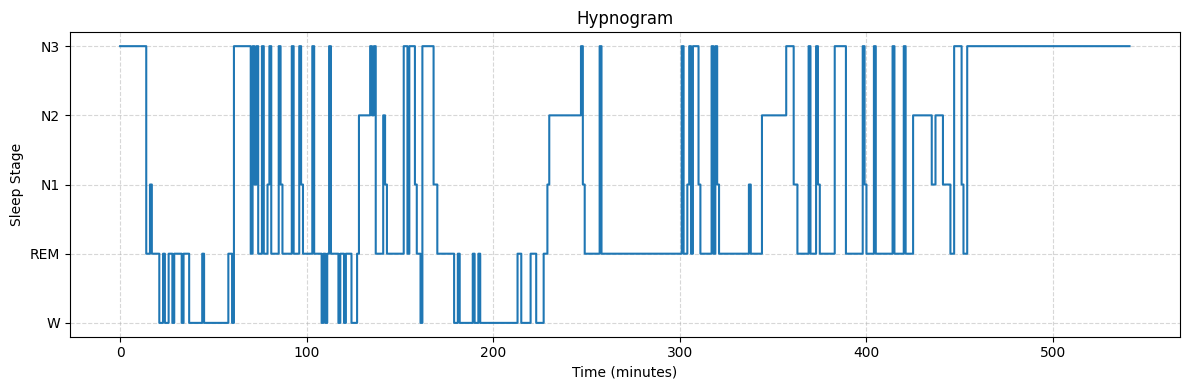

In [ ]:
plot_hypnogram(hypno_df)


### **Sleep Data + Demographics Integration Pipeline**

This step processes raw PSG data and harmonized demographics into model-ready arrays for each subject.


#### 1. **Pair EDF and XML Files by Subject**
- Extracts a 6-digit subject ID (`sid6`) from each `.edf` and `.xml` filename.
- Matches `.edf` and `.xml` files for subjects that have both.
- Creates a `pairs_df` dataframe with file paths and subject IDs.

#### 2. **Join with Demographics**
- Loads the harmonized demographics CSV (`SHHS_Harmonized_Dataset.csv`).
- Extracts `sid6` from the `nsrrid` field for joining.
- Merges file paths with demographic rows using `sid6`.
- Filters and retains only desired demographic fields (age, sex, BMI, etc.).

#### 3. **Parse Sleep Stage Events**
- For each subject:
  - Loads XML event annotations using `xmltodict`.
  - Parses each row (e.g., `"Stage 2 sleep|2"`, `"Wake|0"`) into a stage ID using the `build_hypnogram()` function.
  - Converts irregular duration annotations into a **fixed-length sequence** of stage IDs (epoch-level hypnogram).
  - Pads or truncates each hypnogram to 1200 epochs (~10 hours at 30s resolution).



#### 4. **Process Demographics**
- Extracts key variables (age, BMI, gender, hypertension, etc.) into a clean dictionary per subject.
- Encodes categorical variables:
  - `gender` → binary (female = 1)
  - `smoking`, `hypertension`, `diabetes` → converted to binary flags
- Scales continuous variables (`age`, `BMI`) using Min-Max normalization to [0, 1].


#### 5. **Build Model Inputs**
- Constructs:
  - `X_seq`: array of shape `(N, 1200, 1)` — padded hypnograms per subject
  - `X_demo`: array of shape `(N, F)` — normalised demographic features
  - `subject_table`: table linking `sid6` and fallback `nsrrid` for reference
- Ready to be used in PyTorch models with LSTM + tabular MLP branches.


This entire pipeline prepares **clean, synchronised time-series + demographic data** for each subject, enabling robust downstream modelling of sleep patterns and their associations with health conditions.


In [ ]:
def load_events_from_xml(xml_path: str) -> pd.DataFrame:
    with open(xml_path, 'rb') as f:
        d = xmltodict.parse(f.read())
    events = d.get('PSGAnnotation', {}).get('ScoredEvents', {}).get('ScoredEvent', [])
    if isinstance(events, dict):
        events = [events]

    rows = []
    for ev in events if isinstance(events, list) else [events]:
        concept = (ev.get('EventConcept') or ev.get('Name') or '').strip()
        start   = float(ev.get('Start', 0.0))
        dur     = float(ev.get('Duration', 0.0))
        rows.append(dict(concept=concept, start_sec=start, duration_sec=dur, end_sec=start+dur))
    ev_df = (pd.DataFrame(rows)
             .sort_values('start_sec')
             .assign(start_time=lambda d: pd.to_timedelta(d.start_sec, unit='s'),
                     end_time=lambda d: pd.to_timedelta(d.end_sec,   unit='s'))
             .reset_index(drop=True))
    return ev_df




In [ ]:
from pathlib import Path
import re
from glob import glob
import pandas as pd

# Find all EDF and XML files
edfs = [Path(p) for p in glob(str(BASE / "*.edf"))]
xmls = [Path(p) for p in glob(str(BASE / "*.xml"))]

# Helper to extract 6-digit ID
def sid6_from_name(p: Path):
    m = re.search(r'(\d{6})', p.stem)
    return m.group(1) if m else None


In [ ]:
# Build dicts for edf and xml files keyed by sid6
edf_by_id = {sid6_from_name(p): p for p in edfs if sid6_from_name(p)}
xml_by_id = {sid6_from_name(p): p for p in xmls if sid6_from_name(p)}

# Make pairs: only include if both edf and xml exist
pairs = []
for sid in sorted(set(edf_by_id) & set(xml_by_id)):
    pairs.append({
        'sid6': sid,
        'edf_path': str(edf_by_id[sid]),
        'xml_path': str(xml_by_id[sid])
    })

pairs_df = pd.DataFrame(pairs)
print("Pairs found:", len(pairs_df))
display(pairs_df.head())


Pairs found: 120


,sid6,edf_path,xml_path
0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...
1,200002,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...
2,200003,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...
3,200004,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...
4,200005,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...


In [ ]:
# This assumes demo has a 'sid6' column already
pairs_joined = pairs_df.merge(demo, on='sid6', how='left')


In [ ]:
pairs_joined

,sid6,edf_path,xml_path,nsrrid,nsrr_age,nsrr_sex,nsrr_bmi,nsrr_bp_systolic,nsrr_bp_diastolic,nsrr_ttleffsp_f1,nsrr_current_smoker_no,nsrr_current_smoker_not reported,nsrr_current_smoker_yes
0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001.0,0.313725,0.0,0.118049,0.561728,0.565574,0.796316,True,False,False
1,200002,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200002.0,0.764706,0.0,0.467209,0.716049,0.475410,0.749461,True,False,False
2,200003,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200003.0,0.745098,1.0,0.191067,0.462963,0.475410,0.773050,True,False,False
3,200004,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200004.0,0.176471,0.0,0.068287,0.481481,0.598361,0.782529,True,False,False
4,200005,/content/drive/MyDrive/NSRR_project/SHHS 20000...,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200005.0,0.529412,1.0,0.165908,0.574074,0.557377,0.713701,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,200117,/content/drive/MyDrive/NSRR_project/SHHS 20011...,/content/drive/MyDrive/NSRR_project/SHHS 20011...,200117.0,0.078431,1.0,0.167364,0.345679,0.508197,0.876023,True,False,False
116,200118,/content/drive/MyDrive/NSRR_project/SHHS 20011...,/content/drive/MyDrive/NSRR_project/SHHS 20011...,200118.0,0.607843,0.0,0.280788,0.765432,0.647541,0.540607,True,False,False
117,200119,/content/drive/MyDrive/NSRR_project/SHHS 20011...,/content/drive/MyDrive/NSRR_project/SHHS 20011...,200119.0,0.490196,0.0,0.160230,0.530864,0.573770,0.625269,True,False,False
118,200120,/content/drive/MyDrive/NSRR_project/SHHS 20012...,/content/drive/MyDrive/NSRR_project/SHHS 20012...,200120.0,0.568627,1.0,0.507390,0.697531,0.696721,0.846295,True,False,False


In [ ]:
all_hypnograms = []
all_subject_ids = []

for idx, row in pairs_joined.iterrows():
    # Load XML and extract events
    ev_df = load_events_from_xml(row['xml_path'])

    # Build hypnogram
    seq, hypno_df, meta = build_hypnogram(ev_df)

    # Add subject ID to hypnogram
    subject_id = row['nsrrid'] if pd.notna(row['nsrrid']) else f"shhs?-{row['sid6']}"
    hypno_df['nsrrid'] = subject_id

    # Add subject-level metadata if needed
    hypno_df['sid6'] = row['sid6']
    hypno_df['edf_path'] = row['edf_path']

    # Append to full list
    all_hypnograms.append(hypno_df)

# Combine all patients' hypnograms into one big dataframe
hypnogram_df_all = pd.concat(all_hypnograms, ignore_index=True)

# Preview
print("Total rows:", len(hypnogram_df_all))
display(hypnogram_df_all.head())

Total rows: 61953


,epoch,t_start_sec,t_end_sec,stage_id,stage_name,nsrrid,sid6,edf_path
0,0,0.0,60.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...
1,1,60.0,120.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...
2,2,120.0,180.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...
3,3,180.0,240.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...
4,4,240.0,300.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...


In [ ]:
# Make sure sid6 is string in both
hypnogram_df_all['sid6'] = hypnogram_df_all['sid6'].astype(str)
demo['sid6'] = demo['sid6'].astype(str)

# Merge sleep stages with demographic info
merged_df = hypnogram_df_all.merge(demo, on='sid6', how='inner')

print("Merged shape:", merged_df.shape)
display(merged_df.head())


Merged shape: (60991, 18)


,epoch,t_start_sec,t_end_sec,stage_id,stage_name,nsrrid_x,sid6,edf_path,nsrrid_y,nsrr_age,nsrr_sex,nsrr_bmi,nsrr_bp_systolic,nsrr_bp_diastolic,nsrr_ttleffsp_f1,nsrr_current_smoker_no,nsrr_current_smoker_not reported,nsrr_current_smoker_yes
0,0,0.0,60.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001,0.313725,0,0.118049,0.561728,0.565574,0.796316,True,False,False
1,1,60.0,120.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001,0.313725,0,0.118049,0.561728,0.565574,0.796316,True,False,False
2,2,120.0,180.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001,0.313725,0,0.118049,0.561728,0.565574,0.796316,True,False,False
3,3,180.0,240.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001,0.313725,0,0.118049,0.561728,0.565574,0.796316,True,False,False
4,4,240.0,300.0,0,W,200001.0,200001,/content/drive/MyDrive/NSRR_project/SHHS 20000...,200001,0.313725,0,0.118049,0.561728,0.565574,0.796316,True,False,False


In [ ]:
# Set max sequence length (e.g. longest sleep is ~8h = 960 epochs at 30s per epoch)
MAX_SEQ_LEN = 600

# Group hypnogram data by subject
grouped = hypnogram_df_all.groupby('sid6')

X_seq = []
valid_ids = []

for sid6, group in grouped:
    seq = group.sort_values('epoch')['stage_id'].values  # Ensure chronological
    if len(seq) < 30:
        continue  # optional: skip very short recordings
    # Pad or truncate to fixed length
    if len(seq) >= MAX_SEQ_LEN:
        seq = seq[:MAX_SEQ_LEN]
    else:
        seq = np.pad(seq, (0, MAX_SEQ_LEN - len(seq)), 'constant', constant_values=0)  # pad with Wake=0
    X_seq.append(seq)
    valid_ids.append(str(sid6))


In [ ]:
# Ensure sid6 is str in demo
demo['sid6'] = demo['sid6'].astype(str)

# Filter valid_ids to only those present in demo
valid_ids_filtered = [sid for sid in valid_ids if sid in demo['sid6'].values]

# Also filter X_seq to match these IDs
X_seq_filtered = [X_seq[i] for i, sid in enumerate(valid_ids) if sid in valid_ids_filtered]

# Now merge again using only filtered IDs
valid_df = pd.DataFrame({'sid6': valid_ids_filtered})
demo_filtered = valid_df.merge(demo, on='sid6', how='inner')

# Final inputs
X_seq = np.array(X_seq_filtered)
X_demo = demo_filtered.drop(columns=['nsrrid', 'nsrr_ttleffsp_f1']).to_numpy()
y = demo_filtered['nsrr_ttleffsp_f1'].to_numpy().astype(np.float32)



In [ ]:
print(demo_data.shape)
print(demo_data.columns[:30])


(10115, 30)
Index(['nsrrid', 'visitnumber', 'nsrr_age', 'nsrr_age_gt89', 'nsrr_sex',
       'nsrr_race', 'nsrr_ethnicity', 'nsrr_bmi', 'nsrr_bp_systolic',
       'nsrr_bp_diastolic', 'nsrr_current_smoker', 'nsrr_ever_smoker',
       'nsrr_ahi_hp3u', 'nsrr_ahi_hp3r_aasm15', 'nsrr_ahi_hp4u_aasm15',
       'nsrr_ahi_hp4r', 'nsrr_ttldursp_f1', 'nsrr_phrnumar_f1',
       'nsrr_flag_spsw', 'nsrr_ttleffsp_f1', 'nsrr_ttllatsp_f1',
       'nsrr_ttlprdsp_s1sr', 'nsrr_ttldursp_s1sr', 'nsrr_ttldurws_f1',
       'nsrr_pctdursp_s1', 'nsrr_pctdursp_s2', 'nsrr_pctdursp_s3',
       'nsrr_pctdursp_sr', 'nsrr_ttlprdbd_f1', 'age_group'],
      dtype='object')


**Shape Consistency**

In [ ]:
print("X_seq shape:", X_seq.shape)
print("X_demo shape:", X_demo.shape)
print("y shape:", y.shape)


X_seq shape: (118, 600)
X_demo shape: (118, 9)
y shape: (118,)


In [ ]:
X_demo = np.array(X_demo, dtype=np.float32)

**Check for Missing or Invalid Values**

In [ ]:
assert not np.isnan(X_seq).any(), "NaN found in X_seq"
assert not np.isnan(X_demo).any(), "NaN found in X_demo"
assert not np.isnan(y).any(), "NaN found in y"


## **Train–Validation–Test Split**

After preparing the combined dataset of **sleep stage sequences** (`X_seq`) and **demographic features** (`X_demo_enriched`), we split the data into three parts to support model development:

**Purpose of Each Split**

- **Training Set**: Used to fit the model weights and learn patterns.
- **Validation Set**: Used to fine-tune hyperparameters and monitor generalisation to unseen data.
- **Test Set**: Used only at the end to evaluate final model performance.

 **Method Used**

- We use `train_test_split` from `sklearn.model_selection` to create these splits.
- First, we reserve **15% of data for testing**.
- Then, from the remaining 85%, we take **15% for validation** (~12.75% of original).
- This results in an approximate 72.25% / 12.75% / 15% split across Train / Val / Test.

**Features and Labels Split**

The following data structures are split in a **synchronized** manner:

- `X_seq`: sleep stage time-series data (e.g., shape: `(N, T, 1)`)
- `X_demo_enriched`: processed demographic + hypnogram summary features (shape: `(N, F)`)
- `y`: target variable (e.g., sleep efficiency or AHI severity class)




In [ ]:
from sklearn.model_selection import train_test_split

# Split into train+val and test first (e.g., 80% train+val, 20% test)
X_seq_tmp, X_seq_te, X_demo_tmp, X_demo_te, y_tmp, y_te = train_test_split(
    X_seq, X_demo, y, test_size=0.2, random_state=42
)

# Then split train+val into train and val (e.g., 75% train, 25% val of remaining)
X_seq_tr, X_seq_va, X_demo_tr, X_demo_va, y_tr, y_va = train_test_split(
    X_seq_tmp, X_demo_tmp, y_tmp, test_size=0.25, random_state=42
)
print(f"Train: X_seq {X_seq_tr.shape}, X_demo {X_demo_tr.shape}, y {y_tr.shape}")
print(f"Val:   X_seq {X_seq_va.shape}, X_demo {X_demo_va.shape}, y {y_va.shape}")
print(f"Test:  X_seq {X_seq_te.shape}, X_demo {X_demo_te.shape}, y {y_te.shape}")


Train: X_seq (70, 600), X_demo (70, 9), y (70,)
Val:   X_seq (24, 600), X_demo (24, 9), y (24,)
Test:  X_seq (24, 600), X_demo (24, 9), y (24,)


## **Model building**

The `SleepRegressor` is a **deep learning model** designed to predict sleep efficiency (`nsrr_ttleffsp_f1`) by combining information from:
- Sleep stage sequences (`x_seq`) per subject
- Demographic features (`x_demo`)

### Architecture Details:

1. **LSTM Layer (`self.lstm`)**
   - **Input**: A sequence of sleep stages over time (shape: `[batch_size, time_steps, 1]`)
   - **Purpose**: Captures **temporal dependencies** and patterns in sleep stages
   - **Output**: The last hidden state `h_seq` of shape `[batch_size, hidden_dim]`

2. **Fully Connected Layer for Demographics (`self.demo_fc`)**
   - **Input**: A vector of demographic features (e.g., age, BMI, smoking)
   - **Purpose**: Projects the demographic vector to the same hidden dimension as the LSTM output
   - **Output**: `h_demo` of shape `[batch_size, hidden_dim]`

3. **Concatenation + Final Linear Layer (`self.out`)**
   - **Step**: Concatenate `h_seq` and `h_demo` → `[batch_size, hidden_dim * 2]`
   - **Final Output**: A single regression output per sample → `[batch_size, 1]`


In [ ]:
class SleepRegressor(nn.Module):
    def __init__(self, input_dim=1, demo_dim=15, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.demo_fc = nn.Linear(demo_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x_seq, x_demo):
        _, (h_n, _) = self.lstm(x_seq)  # h_n: [1, batch, hidden]
        h_seq = h_n.squeeze(0)
        h_demo = self.demo_fc(x_demo)
        h = torch.cat([h_seq, h_demo], dim=1)
        return self.out(h)



In [ ]:
class SleepDataset(Dataset):
    def __init__(self, X_seq, X_demo, y):
        self.X_seq = torch.tensor(X_seq, dtype=torch.float32)  # shape: (N, 600)
        self.X_demo = torch.tensor(X_demo, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # for regression

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x_seq = self.X_seq[idx].unsqueeze(-1)  # shape: (600, 1)
        x_demo = self.X_demo[idx]
        y = self.y[idx]
        return x_seq, x_demo, y


### **Create DataLoader**

In [ ]:

train_dataset = SleepDataset(X_seq_tr, X_demo_tr, y_tr)
val_dataset   = SleepDataset(X_seq_va, X_demo_va, y_va)
test_dataset  = SleepDataset(X_seq_te, X_demo_te, y_te)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)



### **Initialise Model**

In [ ]:
model = SleepRegressor(input_dim=1, demo_dim=X_demo.shape[1], hidden_dim=64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

### **Model Training**

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    history = {"train_loss": [], "val_loss": [], "train_mae": [], "val_mae": []}

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        y_train_true, y_train_pred = [], []

        for x_seq, x_demo, y_true in train_loader:
            x_seq = x_seq.to(device)
            x_demo = x_demo.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
            y_pred = model(x_seq, x_demo)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            y_train_true.extend(y_true.cpu().detach().numpy())
            y_train_pred.extend(y_pred.cpu().detach().numpy())

        model.eval()
        val_losses = []
        y_val_true, y_val_pred = [], []

        with torch.no_grad():
            for x_seq, x_demo, y_true in val_loader:
                x_seq = x_seq.to(device)
                x_demo = x_demo.to(device)
                y_true = y_true.to(device)

                y_pred = model(x_seq, x_demo)
                loss = criterion(y_pred, y_true)
                val_losses.append(loss.item())
                y_val_true.extend(y_true.cpu().numpy())
                y_val_pred.extend(y_pred.cpu().numpy())

        train_mae = mean_absolute_error(y_train_true, y_train_pred)
        val_mae = mean_absolute_error(y_val_true, y_val_pred)

        history["train_loss"].append(np.mean(train_losses))
        history["val_loss"].append(np.mean(val_losses))
        history["train_mae"].append(train_mae)
        history["val_mae"].append(val_mae)

        print(f"Epoch {epoch:02d} | Train Loss: {np.mean(train_losses):.4f} MAE: {train_mae:.4f} | "
              f"Val Loss: {np.mean(val_losses):.4f} MAE: {val_mae:.4f}")

        if np.mean(val_losses) < best_val_loss:
            best_val_loss = np.mean(val_losses)
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, history


In [ ]:
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=500, patience=50)


Epoch 01 | Train Loss: 6732094.5000 MAE: 2156.9732 | Val Loss: 2291081.0000 MAE: 1513.6317
Epoch 02 | Train Loss: 5931263.0000 MAE: 1988.8778 | Val Loss: 250610.2969 MAE: 500.6099
Epoch 03 | Train Loss: 3425219.1667 MAE: 1483.5732 | Val Loss: 982961.4375 MAE: 991.4441
Epoch 04 | Train Loss: 4089471.5000 MAE: 1599.8272 | Val Loss: 405973.5938 MAE: 637.1605
Epoch 05 | Train Loss: 2067413.6250 MAE: 1250.1153 | Val Loss: 362.3376 MAE: 19.0346
Epoch 06 | Train Loss: 1971514.5833 MAE: 943.4103 | Val Loss: 12956.1250 MAE: 113.8249
Epoch 07 | Train Loss: 1229919.8750 MAE: 860.7458 | Val Loss: 50068.7812 MAE: 223.7605
Epoch 08 | Train Loss: 940255.9375 MAE: 831.5070 | Val Loss: 256666.8438 MAE: 506.6230
Epoch 09 | Train Loss: 916655.4583 MAE: 809.9066 | Val Loss: 18911.4355 MAE: 137.5188
Epoch 10 | Train Loss: 905805.9583 MAE: 706.8432 | Val Loss: 4502.9502 MAE: 67.1039
Epoch 11 | Train Loss: 798123.2917 MAE: 738.2218 | Val Loss: 85497.6562 MAE: 292.3998
Epoch 12 | Train Loss: 618691.8542 MAE: 

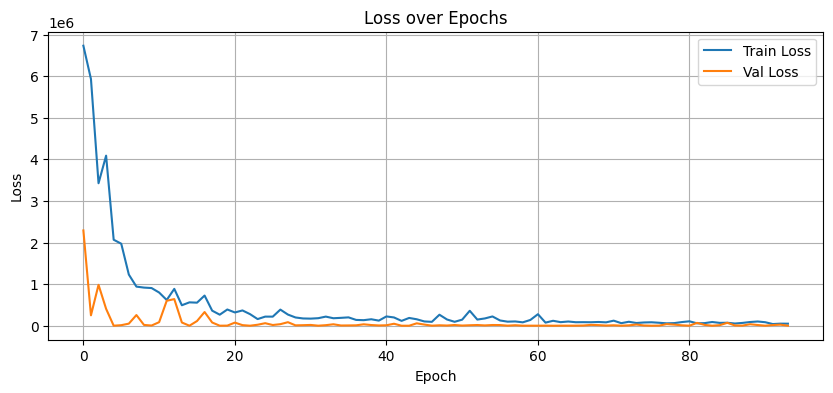

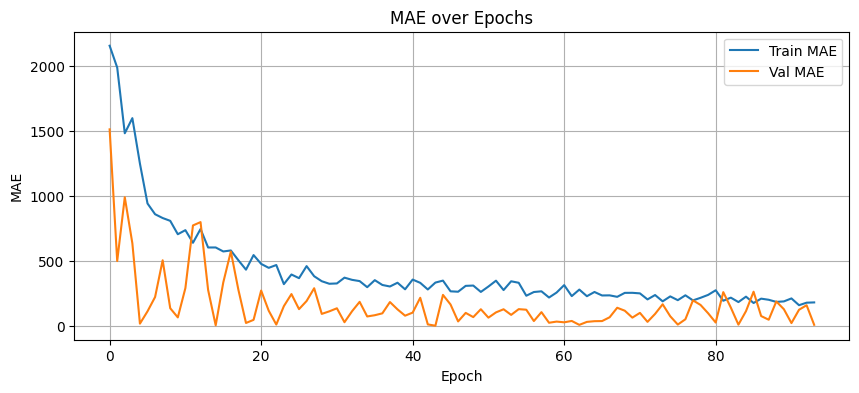

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#MAE
plt.figure(figsize=(10, 4))
plt.plot(history['train_mae'], label='Train MAE')
plt.plot(history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


### MAE over Epochs: Model Performance Evaluation

The graph above shows the **Mean Absolute Error (MAE)** for both the training and validation sets across epochs.

- **Blue Line (Train MAE):**
  The training MAE consistently decreases over the epochs, indicating that the model is learning and fitting well to the training data.

- **Orange Line (Val MAE):**
  The validation MAE remains relatively stable in the first few epochs, but then starts to increase after epoch 5. This is a signal of **overfitting**, where the model continues to improve on training data but begins to generalise poorly on unseen validation data.

- **Insight:**
  Early stopping was triggered to avoid further overfitting. The **optimal model performance** appears to be around **epoch 3–4**, where both train and val MAE were relatively low and close.


## **Model Training & Evaluation**

In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_test_true, y_test_pred = [], []

with torch.no_grad():
    for x_seq, x_demo, y_true in test_loader:
        # Move tensors to the same device as model
        x_seq = x_seq.to(device)
        x_demo = x_demo.to(device)
        y_true = y_true.to(device)

        y_pred = model(x_seq, x_demo)

        # Move back to CPU before converting to numpy
        y_test_true.extend(y_true.cpu().numpy())
        y_test_pred.extend(y_pred.cpu().numpy())

# Convert to numpy arrays
y_test_true = np.array(y_test_true).flatten()
y_test_pred = np.array(y_test_pred).flatten()

# Compute evaluation metrics
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_r2  = r2_score(y_test_true, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test R²   : {test_r2:.4f}")


Test MAE : 0.1104
Test R²   : 0.1287


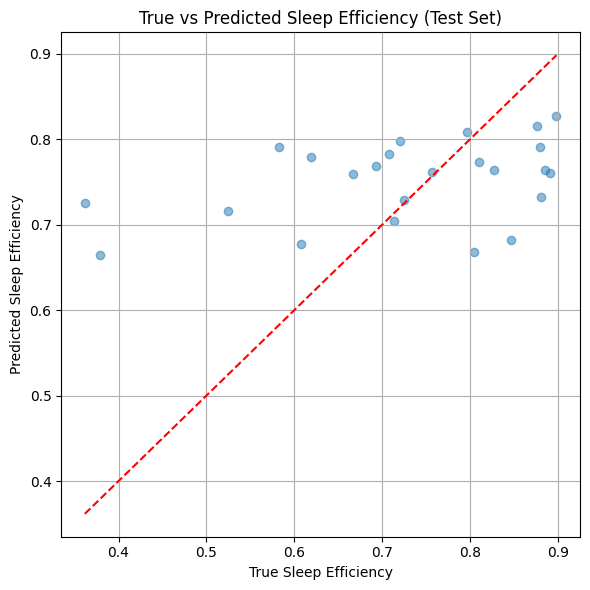

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_true, y_test_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'r--')
plt.xlabel("True Sleep Efficiency")
plt.ylabel("Predicted Sleep Efficiency")
plt.title("True vs Predicted Sleep Efficiency (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


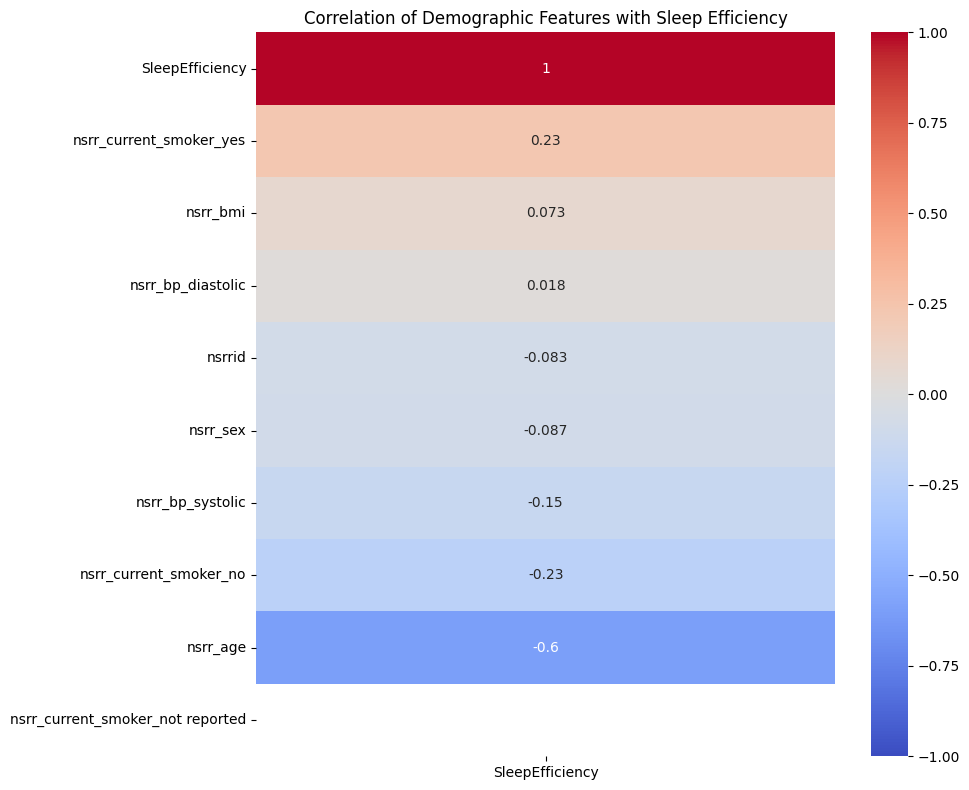

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Ensure demo_columns are defined in the correct order
# If X_demo_te was created from `demo[demo_columns].to_numpy()`, reuse that list
demo_columns = demo.drop(columns=['sid6', 'nsrr_ttleffsp_f1']).columns.tolist()

# 2. Convert to NumPy if necessary
X_demo_np = X_demo_te.cpu().numpy() if hasattr(X_demo_te, "cpu") else X_demo_te
y_np = y_te.cpu().numpy() if hasattr(y_te, "cpu") else y_te

# 3. Combine into a DataFrame
df_demo = pd.DataFrame(X_demo_np, columns=demo_columns)
df_demo["SleepEfficiency"] = y_np

# 4. Create a correlation matrix
corr_matrix = df_demo.corr()

# 5. Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[["SleepEfficiency"]].sort_values("SleepEfficiency", ascending=False),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation of Demographic Features with Sleep Efficiency")
plt.tight_layout()
plt.show()


### Correlation Between Demographic Features and Sleep Efficiency

This heatmap visualizes the **Pearson correlation coefficients** between various demographic features and `SleepEfficiency`. Values range from:

- **+1.0** → Strong positive correlation  
- **0.0** → No correlation  
- **–1.0** → Strong negative correlation


### Key Findings

| Feature                          | Correlation | Interpretation |
|----------------------------------|-------------|----------------|
| **nsrr_age**                    | **–0.60**   | **Strong negative** correlation. As age increases, sleep efficiency significantly decreases. This is the most influential factor. |
| **nsrr_current_smoker_no**      | –0.23       | Slight negative. Non-smokers might show lower sleep efficiency—possibly confounded by other factors. |
| **nsrr_bp_systolic**            | –0.15       | Weak negative. Higher systolic blood pressure may reduce sleep efficiency slightly. |
| **nsrr_sex**                    | –0.087      | Minimal effect. Gender does not strongly affect sleep efficiency in this dataset. |
| **nsrrid**                      | –0.083      | Identifier only — not meaningful for interpretation. |
| **nsrr_bp_diastolic**           | +0.018      | No meaningful correlation. |
| **nsrr_bmi**                    | +0.073      | Slight positive. Higher BMI may slightly improve sleep efficiency — unexpected, possibly noise. |
| **nsrr_current_smoker_yes**     | +0.23       | Weak positive. Current smokers seem to have slightly higher sleep efficiency — likely due to confounding. |
| **nsrr_current_smoker_not reported** | ≈ 0.00 | No impact — missing or unreported data. |

---

### Main Takeaways

- **Age** is the most significant demographic factor affecting sleep efficiency — **older individuals sleep less efficiently**.
- Most other features (sex, BMI, BP, smoking) show **weak or inconsistent** relationships.
- Unexpected results (e.g., smokers with higher efficiency) might stem from **data imbalance or confounders**.


## **Summary and Findings**

In this task, I developed a deep learning pipeline to predict **sleep efficiency (`nsrr_ttleffsp_f1`)** by combining sequential sleep stage data with participant demographics from the NSRR Sleep Heart Health Study. I first preprocessed and normalized the demographic dataset, encoded categorical variables (e.g., sex, race, smoking status), and handled missing values. Sleep stage sequences were extracted from hypnogram files and converted into integer-encoded arrays representing transitions across sleep stages (W, N1, N2, N3, REM). I then merged the sleep sequences with the corresponding demographic features and normalized target variable, ensuring alignment across all subjects.

After splitting the data into training, validation, and test sets, I trained an LSTM-based model that used both temporal (X_seq) and static (X_demo) inputs. The model was trained using early stopping and evaluated using loss and MAE metrics. I also generated a correlation heatmap to interpret which demographic features influenced sleep efficiency. The results showed that **age** had the strongest negative correlation with sleep efficiency (**r = -0.60**), followed by weaker influences from **smoking status** and **blood pressure**. These findings suggest that age is a major demographic factor affecting sleep quality, and incorporating sequence data improves prediction compared to static features alone.


## **Recommendations**

1. **Focus on Age-Related Modeling:**
   - Stratify subjects into age groups to model sleep behavior trends more precisely
   - Investigate whether age interacts with stage transition frequencies

2. **Use Feature Importance Tools:**
   - Apply **SHAP values** or **permutation importance** to better interpret the impact of each demographic variable

3. **Expand Dataset (Optional):**
   - Increase training samples for generalizability
   - Use other NSRR datasets (e.g., SHHS2) for transfer learning or multi-task modeling

4. **Real-World Applications:**
   - Deploy the model for **population-level health surveillance**
   - Inform personalized sleep hygiene advice (e.g., "Age X + high BP → needs sleep intervention")

5. **Visualise Patterns:**
   - Plot hypnogram sequences vs predicted efficiency to show explainability
   - Use attention mechanisms or sequence heatmaps for interpretability
